# TODO:

- finish data generation
- build model
- train model

In [1]:
%autosave 120

Autosaving every 120 seconds


# Setup and Data Import

In [2]:
from PIL import Image
import os
from matplotlib import pyplot as plt
from os.path import abspath
import numpy as np
import pandas as pd
import random

In [3]:
def local_or_hosted():

    if 'content' in os.getcwd():
        L_or_H = 'hosted'
      
    else:
        L_or_H = 'locally'
    
    return L_or_H

############

def colab_setup(L_or_H):

    if L_or_H == 'hosted':

        %cd -q /content/
        
        #check if git clone already performed
        if not os.path.isdir('./lymphoma_classifier'):
            !git clone https://github.com/andy-j-block/lymphoma_classifier.git
            
        %cd -q /content/lymphoma_classifier
        current_dir = os.getcwd()
        print(f"Current directory is '{current_dir}'")


############      

def load_images(images_main_dir):
    
    # get cancer type strings
    cancer_types = [type_ for type_ in os.listdir(images_main_dir)]

    # get directories where images are stored
    image_dirs = [os.path.join(images_main_dir, type_) for type_ in cancer_types]
    
    # read images into a list
    images = []

    for i, image_dir in enumerate(image_dirs):       
        image_files = os.listdir(image_dir)
        
        for j in image_files:

            # pass thru all the image files per image directory, read the image,
            # add it to the images list
            image_file = os.path.join(image_dirs[i], j)
            image = Image.open(image_file)          
            images.append((cancer_types[i], image, image_file))
                
    return cancer_types, image_dirs, images

###Local or hosted runtime

I like to use Google Colab for its hosted runtime features so I include a check to see if the notebook is being run locally or hosted.

In [4]:
L_or_H = local_or_hosted()
print(f'This notebook running {L_or_H}.')

This notebook running hosted.


In [5]:
colab_setup(L_or_H)

Cloning into 'lymphoma_classifier'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 442 (delta 13), reused 3 (delta 1), pack-reused 416
Receiving objects: 100% (442/442), 1.36 GiB | 36.53 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Checking out files: 100% (379/379), done.
Current directory is '/content/lymphoma_classifier'


###Data import and image preview

Import the images and store them in a data structure

Cancer types are ['MCL', 'FL', 'CLL']
First image path: ./Images/MCL/sj-05-5326-R1_012.tif
First cancer type: MCL
First image:



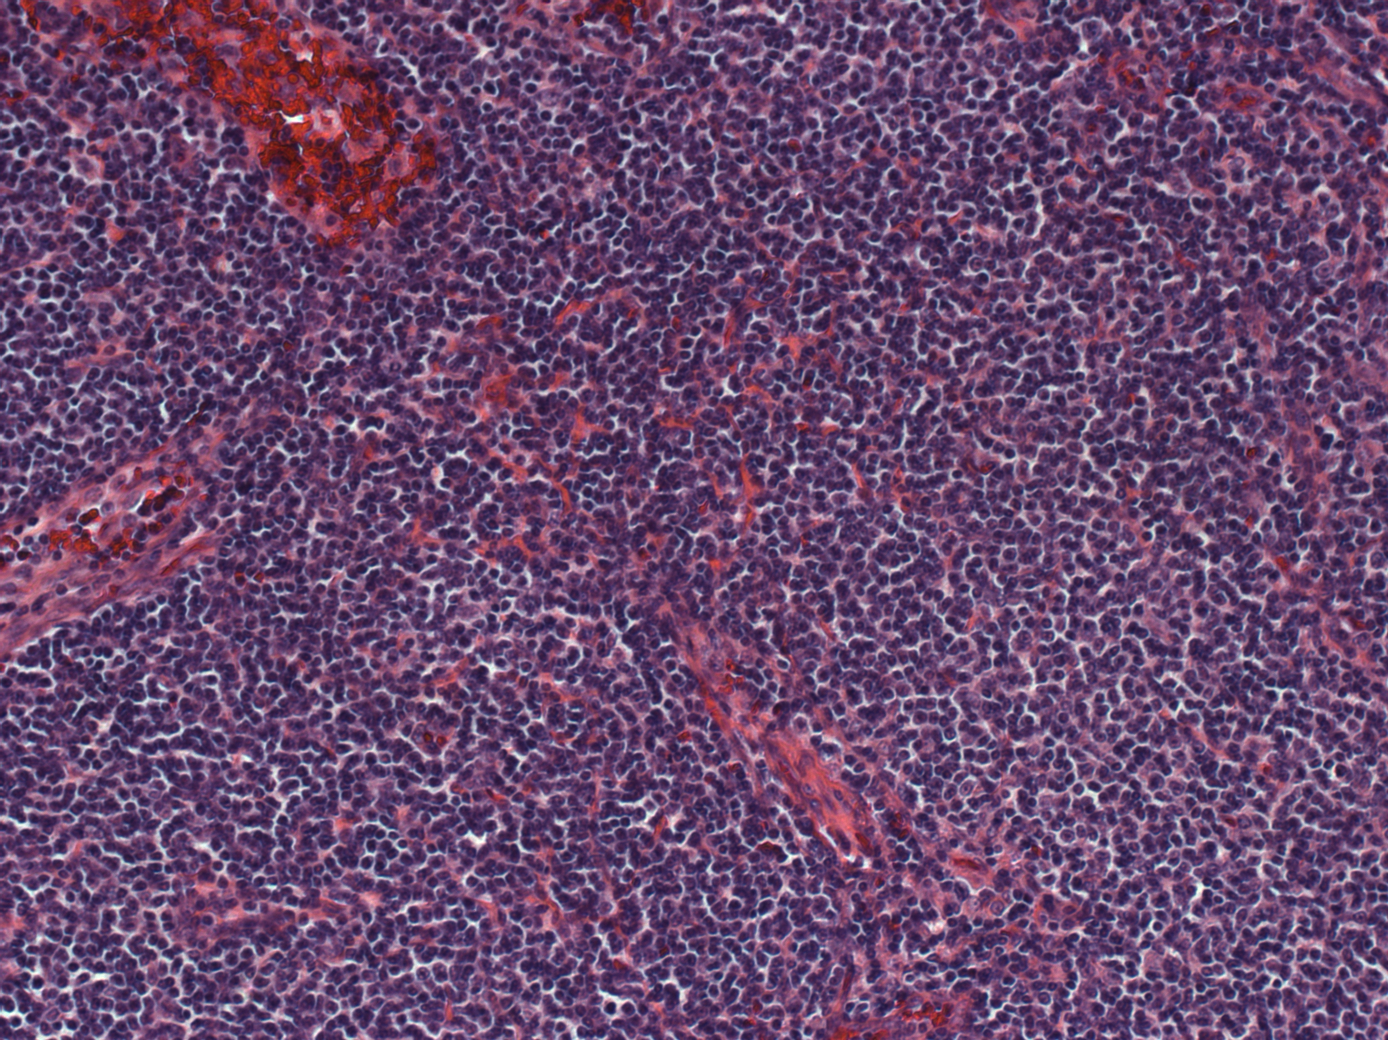

In [6]:
cancer_types, image_dirs, images = load_images('./Images')
print(f'Cancer types are {cancer_types}')
print(f'First image path: {images[0][2]}\nFirst cancer type: {images[0][0]}\nFirst image:\n')
images[0][1]

###Create DataFrame

In [7]:
df = pd.DataFrame(images, columns=['cancer_type', 'image', 'image_path'])
df.head(3)

cancer_type  ...                          image_path
0         MCL  ...  ./Images/MCL/sj-05-5326-R1_012.tif
1         MCL  ...  ./Images/MCL/sj-05-4179-R1_009.tif
2         MCL  ...  ./Images/MCL/sj-04-4525-R4_003.tif

[3 rows x 3 columns]

In [8]:
df['cancer_type'].iloc[1]

'MCL'

# Exploratory Data Analysis

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
def show_value_counts(series):

    print(f'The value counts are:\n{series.value_counts()}')

    percentages = [i/len(df) for i in series.value_counts().values]
    percentages = [round(i,2) for i in percentages]

    fig, ax = plt.subplots(1,1,figsize=(10,5))

    bar_chart=ax.bar(x=series.value_counts().index, 
                    height=series.value_counts().values)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_chart, text_labels):
        for i, bar in enumerate(bar_chart):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    text_labels[i],
                    ha='center', va='bottom')# rotation=0?)
            
    autolabel(bar_chart, percentages)

    plt.title('Count by cancer type with percentages as text')
    plt.show()

############

def get_image_dims(series):

    img_heights = []
    img_widths = []

    for i, _ in enumerate(series):
        img = series.iloc[i]
        width, height = img.size
        img_heights.append(height)
        img_widths.append(width)

    img_heights = set(img_heights)
    img_widths = set(img_widths)
        
    print('Image heights are: ', set(img_heights))
    print('Image widths are: ', set(img_widths))

    return img_heights, img_widths

############

def get_intensity_range(series):

    maxs = []
    mins = []

    for i, _ in enumerate(series):
        maxs.append(np.amax(series.values[i]))
        mins.append(np.amin(series.values[i]))

    print(f'The highest intesity in the range: {max(maxs)}')
    print(f'The lowest intesity in the range: {min(mins)}')

############

def get_random_image(series):

    rand_imgs = []

    for i in image_dirs:
        rand_img = random.choice(series.values)
        rand_imgs.append(rand_img)

    fig, axs = plt.subplots(1, len(rand_imgs), figsize=(30,10))

    for i, img in enumerate(rand_imgs):
        axs[i].set_title(f'Cancer type: {cancer_types[i]}')
        axs[i].imshow(img)

############

def reduce_image_size(series, factor, filter):

    # Filter can be one of Image.NEAREST, Image.BOX, Image.BILINEAR, 
    # Image.HAMMING, Image.BICUBIC or Image.LANCZOS.
    # Default filter is Image.BICUBIC

    for idx, img in enumerate(series.values):
        (width, height) = (img.width // factor, img.height // factor)
        im = img.resize((width, height))
        series.iloc[idx] = im

###Class distribution

The value counts are:
FL     139
MCL    122
CLL    113
Name: cancer_type, dtype: int64


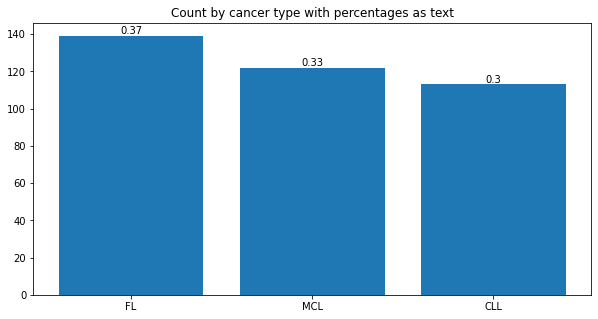

In [11]:
show_value_counts(df['cancer_type'])

###Label Encoding

In [12]:
labels = {'CLL':0, 'FL':1, 'MCL':2}
df['cancer_type']=df['cancer_type'].replace(labels)
df['cancer_type'].value_counts()

1    139
2    122
0    113
Name: cancer_type, dtype: int64

###Image size and color intensity

In [13]:
img_heights, img_widths = get_image_dims(df['image'])

Image heights are:  {1040}
Image widths are:  {1388}


Single value sets mean all images with the same height and width.  Let's confirm the pixel color intensity range

In [14]:
get_intensity_range(df['image'])

The highest intesity in the range: 255
The lowest intesity in the range: 2


I think it's safe to say that these RGB color values range from (0,255).  Color scaling later on will reflect this range

###Sample images

Let's look at a random image of each cancer type.

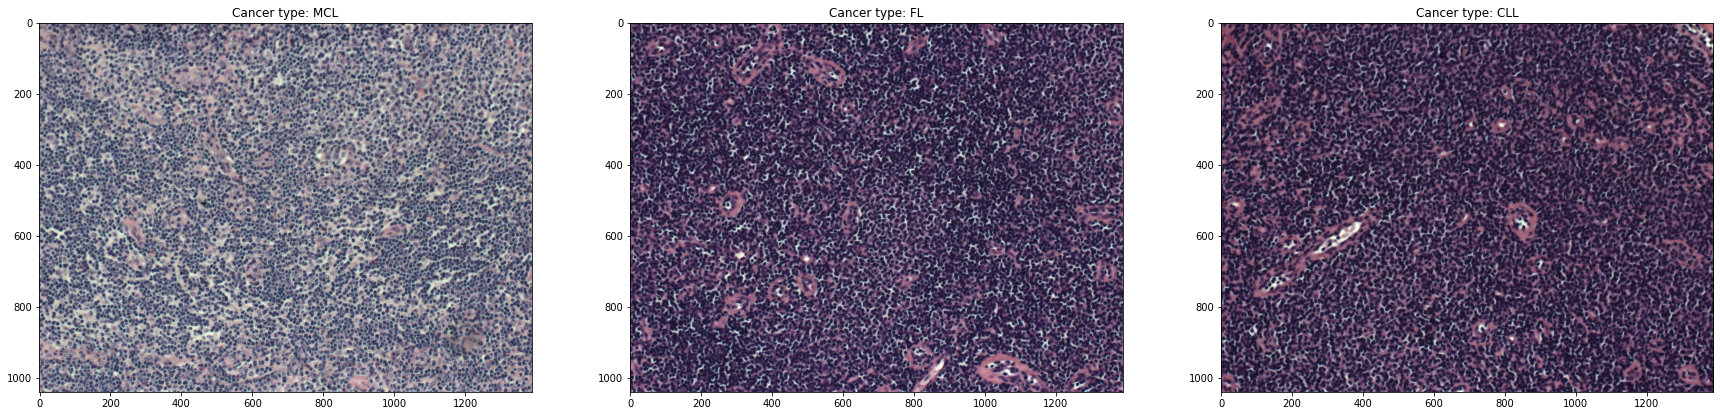

In [15]:
get_random_image(df['image'])

###Image size reduction

In [16]:
reduce_image_size(df['image'], 4, Image.BILINEAR)
img_heights, img_widths = get_image_dims(df['image'])
get_intensity_range(df['image'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Image heights are:  {260}
Image widths are:  {347}
The highest intesity in the range: 255
The lowest intesity in the range: 6


### Define some useful constants for later

In [17]:
image_height = img_heights.pop()
image_width = img_widths.pop()
image_size = (image_width, image_height)
image_channels = 3

# Prepare Data

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
def visualize_sets(full_series, train_series, test_series, titles):

    series = [full_series, train_series, test_series]

    percentages = []
    
    for i, series_ in enumerate(series):

        percentage = [j/len(series_) for j in series_.value_counts().values]
        percentage = [round(j,2) for j in percentage]
        percentages.append(percentage)

    fig, ax = plt.subplots(1,len(series),figsize=(20,5))

    dfs=[]

    for i, series_ in enumerate(series):

        df = ax[i].bar(x=series_.value_counts().index, 
                    height=series_.value_counts().values)
        
        dfs.append(df)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_charts, text_labels):
        for i, chart in enumerate(bar_charts):
            for j, bar in enumerate(chart):
                height = bar.get_height()
                ax[i].text(bar.get_x() + bar.get_width()/2., height,
                        text_labels[i][j],
                        ha='center', va='bottom')# rotation=0?)
            
    autolabel(dfs, percentages)

    for i, title in enumerate(titles):
        ax[i].set_title(title)
    
    plt.show()

###Train test split

We want to create a holdout test set now, but we don't want to split the target variable yet from the image and its path.  When we move onto data generation, we need to keep the target available, so we will just separate the dataframe as a whole.

In [20]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['cancer_type'], random_state=42) 

In [21]:
print(df_train.shape, df_test.shape)

(299, 3) (75, 3)


###Set visualizing

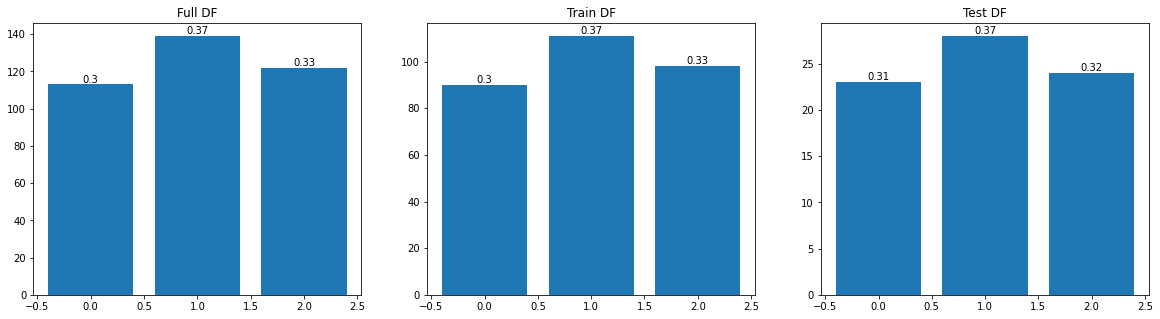

In [22]:
visualize_sets(df['cancer_type'], df_train['cancer_type'], df_test['cancer_type'], ['Full DF', 'Train DF', 'Test DF'])

In [23]:
df_test.head(3)

cancer_type  ...                          image_path
30             2  ...  ./Images/MCL/sj-04-4525-R4_008.tif
360            0  ...     ./Images/CLL/sj-03-5521_004.tif
98             2  ...   ./Images/MCL/sj-05-901-R1_009.tif

[3 rows x 3 columns]

Let's just reset the index here for clarity.

In [24]:
df_test.reset_index(inplace=True, drop=True)
df_test.head(3)

cancer_type  ...                          image_path
0            2  ...  ./Images/MCL/sj-04-4525-R4_008.tif
1            0  ...     ./Images/CLL/sj-03-5521_004.tif
2            2  ...   ./Images/MCL/sj-05-901-R1_009.tif

[3 rows x 3 columns]

In [25]:
df_test['cancer_type'].value_counts()

1    28
2    24
0    23
Name: cancer_type, dtype: int64

###Train val split

The data needs to be split again before generation can occur, that was the validation set generated data doesn't get into the training set.

In [26]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)

In [27]:
df_train.head(3)

cancer_type  ...                          image_path
134            1  ...   ./Images/FL/sj-05-5389-R1_017.tif
349            0  ...  ./Images/CLL/sj-05-3874-R2_008.tif
107            2  ...  ./Images/MCL/sj-05-3362-R2_006.tif

[3 rows x 3 columns]

Again, let's reset our indices.

In [28]:
df_train.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)

# Data Generation

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder

###Device detection

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.backends.cudnn.benchmark = True

cuda


In [31]:
# def load_data(root_path, dir, batch_size, phase):
#     transform_dict = {
#         'src': transforms.Compose(
#         [transforms.RandomResizedCrop(224),
#          transforms.RandomHorizontalFlip(),
#          transforms.ToTensor(),
#          transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                               std=[0.229, 0.224, 0.225]),
#          ]),
#         'tar': transforms.Compose(
#         [transforms.Resize(224),
#          transforms.ToTensor(),
#          transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                               std=[0.229, 0.224, 0.225]),
#          ])}
#     data = datasets.ImageFolder(root=root_path + dir, transform=transform_dict[phase])
#     data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)
#     return data_loader

###Dataset and dataloader

In [32]:
class lymphoma_images_dataset(Dataset):

    def __init__(self, type_, images, paths, transform=None):
        self.type_ = type_
        self.images = images
        self.paths = paths
        self.transform = transform
      
    def __len__(self):
        return len(self.type_)
    
    def __getitem__(self, idx):
        
        image = self.images.iloc[idx]
        path = self.paths.iloc[idx]
        y_label = torch.tensor(int(self.type_.iloc[idx]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

############

def define_dataset(type_series, image_series, path_series, transform, batch_size=1, shuffle=False):

    data = lymphoma_images_dataset(type_series, image_series, path_series, transform=transform)
    loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle)

    return data, loader

In [35]:
rand_apply = transforms.RandomApply(nn.ModuleList([transforms.RandomHorizontalFlip(),
                                                   transforms.RandomVerticalFlip(),
                                                   transforms.ColorJitter(),
                                                   transforms.RandomRotation(degrees=10)
                                                   #transforms.RandomResizedCrop(),

]))

train_transforms = transforms.Compose([transforms.ToTensor(),
                    rand_apply,
                    ])

train_dataset, train_loader = define_dataset(df_train['cancer_type'], df_train['image'], df_train['image_path'], transform=train_transforms, batch_size=8, shuffle=True)
valid_dataset, valid_loader = define_dataset(df_valid['cancer_type'], df_valid['image'], df_valid['image_path'], transform=transforms.ToTensor())

In [64]:
print(len(train_dataset))
print(train_dataset[3][0].shape)

239
torch.Size([3, 260, 347])


###TODO: finish data generation

###Visualize some generated data

TypeError: ignored

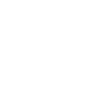

In [63]:
fig = plt.figure()

for i in range(len(train_dataset)):
    im = train_dataset[i][0][:2]
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.axis('off')

    plt.imshow(im)

    if i == 3:
        plt.show()
        break


# Model Build

In [47]:
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

In [50]:
class lymphoma_classifier(nn.Module):

    def __init__(self):
        super(lymphoma_classifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        # initialize weights?? nn.init.kaiming_uniform_, nn.init.xavier_uniform_
        self.ap = nn.AvgPool2d(2)
        self.fc = nn.Linear(1408, 3)

    
    def forward(self, x):
        x = F.relu(self.ap(self.conv1(x)))
        x = x.view(-1)
        x = self.fc(x)
        return F.log_softmax(x)



    # def __init__(self, in_channels):
    #     super(Net, self).__init__()

    #     self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)

    #     self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    #     self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)

    #     self.branch3x3dbl_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    #     self.branch3x3dbl_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
    #     self.branch3x3dbl_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)

    #     self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)


    # def forward(self, x):

    #     branch1x1 = self.branch1x1(x)

    #     branch5x5 = self.branch5x5_1(x)
    #     branch5x5 = self.branch5x5_2(branch5x5)

    #     branch3x3 = self.branch3x3dbl_1(x)
    #     branch3x3 = self.branch3x3dbl_2(branch3x3)
    #     branch3x3 = self.branch3x3dbl_3(branch3x3)

    #     branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
    #     branch_pool = self.branch_pool(branch_pool)

    #     outputs = [branch1x1, branch5x5, branch3x3, branch_pool]

    #     return torch.cat(outputs, 1)




In [51]:
model = lymphoma_classifier()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train the Model



In [53]:
# enumerate epochs
for epoch in range(100):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        yhat = model(inputs)
        loss = criterion(yhat, targets)
        loss.backward()
        optimizer.step()

AttributeError: ignored